In [ ]:
import requests
import pandas as pd
import numpy as np

url = "https://file.notion.so/f/f/f3d54618-4ee1-480d-b8f7-25c361e2c7b2/12d14740-f5b4-4ce9-9d4d-b9d0b3cd5548/data.parquet?table=block&id=6fa5d867-4063-4844-aebb-4be60a25af39&spaceId=f3d54618-4ee1-480d-b8f7-25c361e2c7b2&expirationTimestamp=1764676800000&signature=tGszll6fMy4bN-3DoQ7K2ys3tUweX6u0Zz9bjA5NmBA&downloadName=data.parquet"
r = requests.get(url)
with open("data.parquet", "wb") as f:
    f.write(r.content)

df = pd.read_parquet("data.parquet")
df = df.reset_index()
print(df)

####### I have to find, how many times Consecutive missing blocks are there

### 1.I can remove this row completely
### 2.Using KNN or mean(upper + lower)/2 to fill the missing value(if not consecutive)
### 3.ffill() or bfill() for consecutive missing values(I can)

# df = df.dropna(how='any')
# df.isna().sum()
df.isna()
df.isna().sum()

df = df.ffill()
df.isna().sum()

                      time  banknifty     nifty  tte
0      2021-01-01 09:15:00   0.286058  0.199729   27
1      2021-01-01 09:16:00   0.285381  0.200433   27
2      2021-01-01 09:17:00   0.284233  0.200004   27
3      2021-01-01 09:18:00   0.286104  0.199860   27
4      2021-01-01 09:19:00   0.285539  0.198951   27
...                    ...        ...       ...  ...
690507 2022-06-30 15:26:00   0.240701  0.214758   28
690508 2022-06-30 15:27:00   0.240875  0.216558   28
690509 2022-06-30 15:28:00   0.242115  0.216794   28
690510 2022-06-30 15:29:00   0.243426  0.216455   28
690511 2022-06-30 15:30:00   0.241907  0.216081   28

[690512 rows x 4 columns]


time         0
banknifty    0
nifty        0
tte          0
dtype: int64

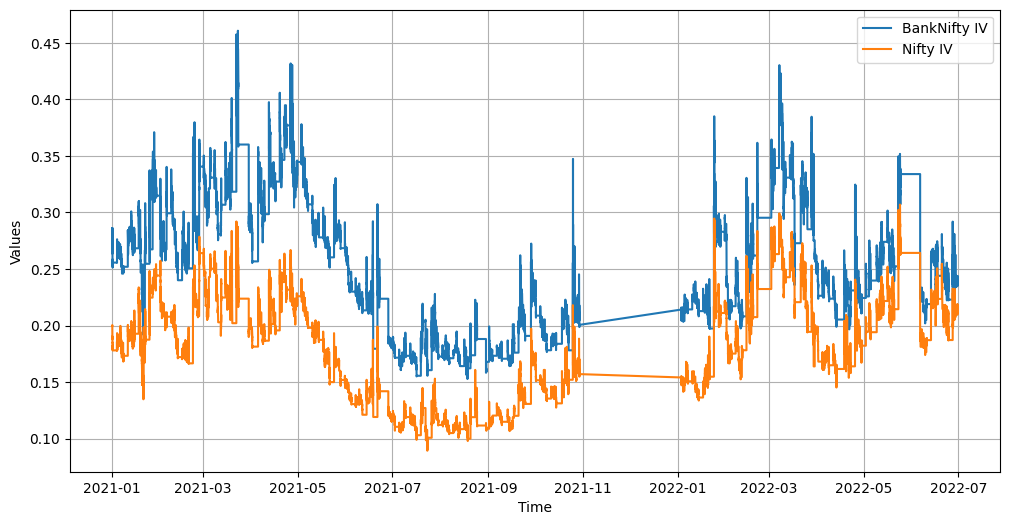

In [2]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,6))
plt.plot(df['time'], df['banknifty'], label='BankNifty IV')
plt.plot(df['time'], df['nifty'], label='Nifty IV')
# plt.plot(df['time'], df['tte'], label='TTE')

plt.xlabel("Time")
plt.ylabel("Values")
plt.legend()
plt.grid(True)
plt.show()

In [ ]:
class SpreadCalculator:
    def __init__(self, window=20):
        self.window = window

    def compute_spread(self, df):
        df['spread'] = df['banknifty'] - df['nifty']
        return df

    def compute_zscore(self, df):
        df['spread_mean'] = df['spread'].rolling(self.window).mean()
        df['spread_std']  = df['spread'].rolling(self.window).std()
        df['zscore']      = (df['spread'] - df['spread_mean']) / df['spread_std']
        df['zscore']      = df['zscore'].replace([np.inf, -np.inf], np.nan).fillna(0)
        return df
    
    def iv_ratio(self, df):
        df['iv_ratio'] = df['banknifty'] / df['nifty']
        df['iv_ratio'] = df['iv_ratio'].replace([np.inf, -np.inf], 0).fillna(0)
        return df

In [ ]:
class PairTrade:
    def __init__(self, entry_time, entry_z, entry_spread, entry_mean, tte, direction, entry_regime):
        self.entry_time   = entry_time
        self.entry_z      = entry_z
        self.entry_spread = entry_spread
        self.entry_mean   = entry_mean
        self.tte          = tte
        self.direction    = direction
        self.entry_regime = entry_regime


    def close(self, exit_time, exit_spread, exit_z, exit_mean, exit_regime):
        self.exit_time    = exit_time
        self.exit_spread  = exit_spread
        self.exit_z       = exit_z
        self.exit_mean    = exit_mean
        self.exit_regime  = exit_regime

        ####### PNL CALC #########
        if self.direction == "LONG":
            pnl = (exit_spread - self.entry_spread) * (self.tte ** 0.7)
        else:
            pnl = (self.entry_spread - exit_spread) * (self.tte ** 0.7)

        return pnl


### 1st Method

In [ ]:
from sklearn.mixture import GaussianMixture
class RegimeDetectorGMM:
    def __init__(self, n_regimes=3):
        self.n_regimes = n_regimes

    def detect(self, df):
        ################ if any case missing columns ########
        if 'spread' not in df.columns:
            df['spread'] = df['banknifty'] - df['nifty']
        if 'zscore' not in df.columns:
            df['zscore'] = 0
        if 'iv_ratio' not in df.columns:
            df['iv_ratio'] = (df['banknifty'] / df['nifty']).replace([np.inf, -np.inf], 0).fillna(0)
            
        ############## Feature set for regime detection(I can add more features if needed) ##############
        X = np.column_stack([
            df['spread'].values,
            df['zscore'].values,
            df['iv_ratio'].values,
        ])

        ######### Fit GMM ##########
        gmm = GaussianMixture(n_components=self.n_regimes, covariance_type='full', random_state=42)
        df['regime'] = gmm.fit_predict(X)
        return df, gmm



In [6]:
class PairTradingStrategy:
    def __init__(self, upper, lower, exit_threshold, window, bnIV_sl=None, nfIV_sl=None, use_regime_filter=True, allowed_regimes=None):
        self.upper          = upper
        self.lower          = lower
        self.exit_mid       = (upper + lower) / 2
        self.bnIV_sl        = bnIV_sl
        self.nfIV_sl        = nfIV_sl
        self.spread_model   = SpreadCalculator(window)

        self.open_trade        = None
        self.ledger            = []

        ############## Regime filtering ##############
        self.use_regime_filter = use_regime_filter
        self.allowed_regimes   = allowed_regimes or [0]


    def process(self, df):
        df = self.spread_model.compute_spread(df)
        df = self.spread_model.compute_zscore(df)

        ########### Apply Regime Detection ############
        regime_detector = RegimeDetectorGMM(n_regimes=3)
        df, _           = regime_detector.detect(df)

        for idx, row in df.iterrows():
            current_time = idx
            z            = row['zscore']
            spread       = row['spread']
            mean_val     = row['spread_mean']
            bankIV       = row['banknifty']
            niftyIV      = row['nifty']
            tte          = row['tte']
            regime       = row['regime']

            #################### ENTRY Conditions ##################
            if self.open_trade is None:
                ############### Skip if regime is not in allowed #################
                if self.use_regime_filter and (regime not in self.allowed_regimes):
                    continue
                ########### SHORT ENTRY at upper band
                if z > self.upper:
                    self.open_trade = PairTrade(
                        entry_time   = current_time,
                        entry_z      = z,
                        entry_spread = spread,
                        entry_mean   = mean_val,
                        tte          = tte,
                        direction    = "SHORT",
                        entry_regime = regime
                    )

                ############ LONG ENTRY at lower band   
                elif z < self.lower:
                    self.open_trade = PairTrade(
                        entry_time   = current_time,
                        entry_z      = z,
                        entry_spread = spread,
                        entry_mean   = mean_val,
                        tte          = tte,
                        direction    = "LONG",
                        entry_regime = regime
                    )
                continue


            ################ EXIT CONDITIONS #################
            sl_hit = False
            if self.bnIV_sl is not None and bankIV > self.bnIV_sl:
                sl_hit = True
            if self.nfIV_sl is not None and niftyIV > self.nfIV_sl:
                sl_hit = True

            ################## Stop-loss triggered ###################
            if sl_hit:
                pnl = self.open_trade.close(
                    exit_time    = current_time,
                    exit_spread  = spread,
                    exit_z       = z,
                    exit_mean    = mean_val,
                    exit_regime  = regime     
                )
                self.ledger.append(self._make_ledger_entry(regime, pnl))
                self.open_trade = None
                continue

            #################### Exit at midPoint (new exit logic) ##########
            if self.open_trade.direction == "SHORT" and z <= self.exit_mid:
                pnl = self.open_trade.close(
                    exit_time    = current_time,
                    exit_spread  = spread,
                    exit_z       = z,
                    exit_mean    = mean_val,
                    exit_regime  = regime
                )
                self.ledger.append(self._make_ledger_entry(regime, pnl))
                self.open_trade = None

            elif self.open_trade.direction == "LONG" and z >= self.exit_mid:
                pnl = self.open_trade.close(
                    exit_time    = current_time,
                    exit_spread  = spread,
                    exit_z       = z,
                    exit_mean    = mean_val,
                    exit_regime  = regime
                )
                self.ledger.append(self._make_ledger_entry(regime, pnl))
                self.open_trade = None

        return pd.DataFrame(self.ledger)

    
    ################### store ###################
    def _make_ledger_entry(self, exit_regime, pnl):
        return {
            "entry_time"       : self.open_trade.entry_time,
            "exit_time"        : self.open_trade.exit_time,
            "direction"        : self.open_trade.direction,
            "entry_spread"     : self.open_trade.entry_spread,
            "exit_spread"      : self.open_trade.exit_spread,
            "entry_zscore"     : self.open_trade.entry_z,
            "exit_zscore"      : self.open_trade.exit_z,
            "entry_mean_zscore": self.open_trade.entry_mean,
            "exit_mean_zscore" : self.open_trade.exit_mean,                   
            "pnl"              : pnl,
            "entry_regime"     : self.open_trade.entry_regime,
            "exit_regime"      : exit_regime 
        }


In [7]:
# strategy = PairTradingStrategy(upper=1.26, lower=-1.26, exit_threshold=0.1, window=30, use_regime_filter=True, allowed_regimes=[0, 1])
strategy = PairTradingStrategy(upper=1.26, lower=-1.26, exit_threshold=0.1, window=30, bnIV_sl=0.5, nfIV_sl=0.5, use_regime_filter=True, allowed_regimes=[0, 1])

ledger = strategy.process(df)
print(ledger)


      entry_time  exit_time direction  entry_spread  exit_spread  \
0           9015       9044      LONG      0.061105     0.061105   
1          27362      27363      LONG      0.064262     0.070444   
2          27385      27403      LONG      0.064409     0.067451   
3          27432      27438      LONG      0.063705     0.065778   
4          27442      27450      LONG      0.064023     0.065112   
...          ...        ...       ...           ...          ...   
4338      690445     690449     SHORT      0.026418     0.024590   
4339      690454     690455     SHORT      0.026546     0.024200   
4340      690459     690467     SHORT      0.026158     0.025251   
4341      690472     690492     SHORT      0.027703     0.026356   
4342      690496     690510      LONG      0.024572     0.026971   

      entry_zscore  exit_zscore  entry_mean_zscore  exit_mean_zscore  \
0        -3.558748     0.000000           0.069051          0.061105   
1        -5.020115     1.537670        

In [12]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

def plot_regime_zscore(df, start_time=None, end_time=None, regime_col="regime"):
    plt.style.use("ggplot")

    # Ensure datetime index
    if not isinstance(df.index, pd.DatetimeIndex):
        df['time'] = pd.to_datetime(df['time'])
        df = df.set_index('time')

    # Filter time
    if start_time is not None:
        df = df[df.index >= pd.to_datetime(start_time)]
    if end_time is not None:
        df = df[df.index <= pd.to_datetime(end_time)]

    # Setup figure
    fig, ax = plt.subplots(figsize=(16, 6))

    # ---------------- REGIME SHADING ----------------
    regimes = sorted(df[regime_col].unique())
    colors = plt.cm.tab20(np.linspace(0, 1, len(regimes)))

    ymin, ymax = df["zscore"].min(), df["zscore"].max()

    for r, c in zip(regimes, colors):
        mask = df[regime_col] == r
        ax.fill_between(
            df.index,
            ymin, ymax,
            where=mask,
            color=c,
            alpha=0.15,
            label=f"Regime {r}"
        )

    # ---------------- Z-SCORE LINE ----------------
    ax.plot(df.index, df["zscore"], color="blue", label="Z-Score", linewidth=1.5)

    # ---------------- BANDS ----------------
    ax.axhline(1.26, color="red",   linestyle="--", label="Upper Band (1.26)")
    ax.axhline(-1.26, color="green", linestyle="--", label="Lower Band (-1.26)")
    ax.axhline(0, color="black", linewidth=1)

    ax.set_title("Z-Score with GMM Regime Coloring")
    ax.legend(loc="upper left", ncol=4)
    plt.tight_layout()
    plt.show()


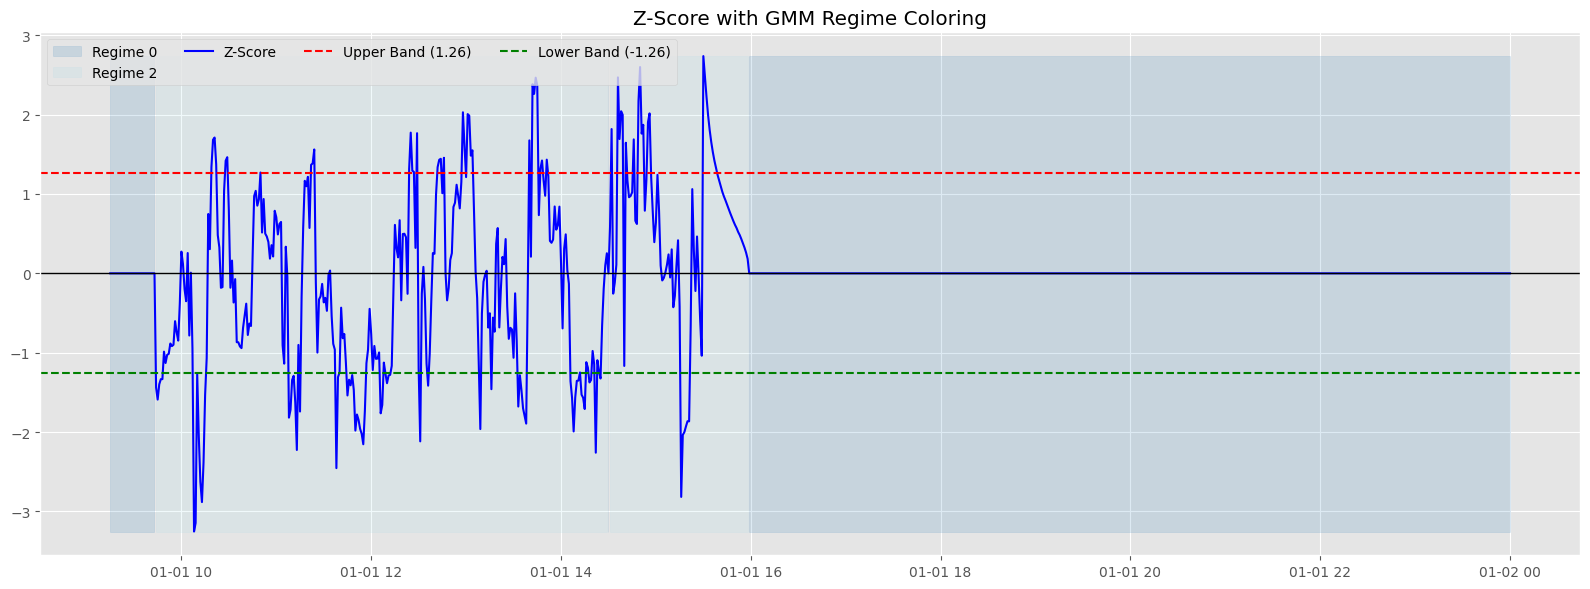

In [14]:
plot_regime_zscore(df, start_time="2021-01-01", end_time="2021-01-02")


In [15]:
class StrategyMetrics:    
    def __init__(self, ledger_df):
        self.ledger = ledger_df.copy()
        if self.ledger.empty:
            raise ValueError("Ledger is empty, No trades executed.")

        self.returns = self.ledger["pnl"]

    def total_pnl(self):
        return self.returns.sum()

    def sharpe_ratio(self):
        if self.returns.std() == 0:
            return 0
        return (self.returns.mean() / self.returns.std()) * np.sqrt(252)

    def max_drawdown(self):
        cum = self.returns.cumsum()
        roll_max = cum.cummax()
        drawdown = roll_max - cum
        return drawdown.max()

    def win_rate(self):
        wins = (self.returns > 0).sum()
        total = len(self.returns)
        return wins / total

    def avg_win(self):
        wins = self.returns[self.returns > 0]
        return wins.mean() if len(wins) > 0 else 0

    def avg_loss(self):
        losses = self.returns[self.returns < 0]
        return losses.mean() if len(losses) > 0 else 0

    def profit_factor(self):
        total_win = self.returns[self.returns > 0].sum()
        total_loss = abs(self.returns[self.returns < 0].sum())
        return total_win / total_loss if total_loss != 0 else np.inf

    def expectancy(self):
        return self.returns.mean()  #avg. p/l per trade

    def summary(self):
        return {
            "Total PnL": self.total_pnl(),
            "Sharpe Ratio": self.sharpe_ratio(),
            "Max Drawdown": self.max_drawdown(),
            "Win Rate": self.win_rate(),
            "Avg Win": self.avg_win(),
            "Avg Loss": self.avg_loss(),
            "Profit Factor": self.profit_factor(),
            "Expectancy": self.expectancy(),
            "Number of Trades": len(self.returns)
        }

In [16]:
metrics = StrategyMetrics(ledger)
print(metrics.summary())

{'Total PnL': 80.41947098811497, 'Sharpe Ratio': 5.923115481085624, 'Max Drawdown': 0.24795106156865643, 'Win Rate': 0.9000690766751094, 'Avg Win': 0.02201834704534222, 'Avg Loss': -0.013951228671920453, 'Profit Factor': 15.232910928629268, 'Expectancy': 0.01851703223304512, 'Number of Trades': 4343}
